# From the article [Text Analytics](https://link.springer.com/article/10.1186/s41039-018-0073-0)
# Quoting the article, the rule based classifier marks sentences as described:
1.
Pattern matching: Phrase that matches with “should”, “could”, “include”, “could have” or some with similar intent phrases are indicators of suggestions. We came up with a list of phrases, a thesaurus through empirically observing students’ comments, similar to [Brun and Hagege](https://www.cicling.org/2013/rcs/Suggestion%20Mining_%20Detecting%20Suggestions%20for%20Improvement%20in%20Users_%20Comments.pdf) (2013).

2.
POS tagged: Modal verbs (MD) are followed by a verb (VB, VBZ, VBP). The task of the speech tagging is performed using NLTK ([Bird et al.](https://dl.acm.org/citation.cfm?id=1717171&preflayout=flat) 2009).

3.
POS tagged extended: Tag list includes noun plural (NNS) and proper noun singular (NNP) as described by [Marcus et al.](https://repository.upenn.edu/cgi/viewcontent.cgi?article=1246&context=cis_reports) (1993).

Run the below cell to import the required libraries. Uncomment the remaining SQL related statements if access to information from the MySQL database is required. Most cells in the notebook require the SQL query from this step, so be sure to run this cell prior to running those. A version fo the suggestoin classifier for imported csv files is present in this notebook and does not need the MySQL query.

In [7]:
import mysql.connector
import nltk
from mysql.connector import errorcode

import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

############### Connect
config = {
    'user': 'readonly',
    'password': 'readpassword',
    'host': 'peerlogic.csc.ncsu.edu',
    'port': '3306',
    'raise_on_warnings': True,
    'database': 'data_warehouse',
}
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

################ Query

query = ("SELECT id, comment FROM answers "
        "WHERE comment LIKE '%could%' OR comment LIKE '%should%' OR comment LIKE 'suggestion';")
query = ("SELECT id, comment FROM answers")
cursor.execute(query)


Use the below cell to create a new csv file with the indicated number of sentences form "num_to_print". Adjusting this value enables a varying length of sentences to be printed up to the maximum read in from the previous SQL query. The output filename under the "with open" statement can be altered to change destination. Uncomment the "writer.writerow" statement to enable printing of sentences.

In [8]:
#### Write sentences to CSV file
count = 0
done = False
num_to_print = 100 # Adjust this value to determine the number of values to print into csv file
import csv
with open('sample_data.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(["Sentence", "Label"])
    for (id, comment) in cursor:
        if comment == None: # Ignore empty comments
            continue
        sentTok = nltk.sent_tokenize(comment)
        for sentence in sentTok:
            if count == num_to_print: # Set the number of sentences to write
                done = True
                break
            if len(sentence) == 1 or len(sentence) == 2:
#                 print(sentence, '\n')
                continue
#             print(sentence, '\n')
            ######## UNCOMMENT BELOW TO WRITE SENTENCES TO CSV FILE
#             writer.writerow([sentence])
            ######## 
#         print(sentence, '\n')
#         output.write(text + '\n')
            count += 1
        if done:
            break

# for (id, comment) in cursor:
#     with open('labeled_sentences.csv', newline = '\n') as csvfile:
#         writer = csv.writer(csvfile, delimiter = '\n', quotechar = '|', quoting = csv.QUOTE_MINIMAL)
#         for count in range(10):
#             count += 1
#             writer.writerow(cursor)

The cell below is used to print statements gathered from the mysql databse query for examination.

In [4]:
#### Print sentences, this is example input, actual data printed to CSV file ####
numPrint = 0
endPrint = False
for (id, comment) in cursor:
    if comment == None: # Ignore empty comments
        continue
    sentTok = nltk.sent_tokenize(comment)
    for sentence in sentTok:
#         print('{', numPrint, '}', sentence, '\n')
        numPrint += 1
        if numPrint == 10:
            endPrint = True
            break
    if endPrint:
        break

The below cell is used to read in datasets to use for the suggestion classifier.
To use, select a pair of "pd.read_csv" and "df.fillna" statements to uncomment and ensure the rest
are commented out. More datasets can be added using the example approaches below.

In [3]:
######### Read in the dataset to use for classifier
# df = pd.read_csv("suggestions_data.csv", engine = 'python', na_values = ['no info', '.', ' ', 'NaN'])
# df.fillna(3, inplace=True)
df = pd.read_csv("suggestions_data_balanced.csv", engine = 'python', na_values = ['no info', '.', ' ', 'NaN'])
df.fillna(3, inplace=True)
# df = pd.read_csv("suggestions_data_tweets.csv", engine = 'python');
# df.fillna(-1, inplace=True)
# df = pd.read_csv("suggestions_trialA.csv", engine = 'python');
# df.fillna(0, inplace=True)

print(df.dtypes)

is_prompt_exists     int64
comments            object
dtype: object


The classifier below is used to find suggestions from the dataset indicated by the previous cell. A report in the form of a visualized confusion matrix and f1 score report are generated. The variable end is set to span the entire dataset. This variable can be adjusted along with altering the loop variables starting point in order to span a different range of inputs from the dataset.
Note: If the "is_prompt_exists" category from the above dataset is read in as an object, then steps are taken to ignore inputs of invalid type (non-numeric label). In this case, ensure that the "if isinstance" set of statements indicated below the start of the first loop is uncommented in order to skip invalid inputs.

Total number of suggestions found: 3467
[[2722  909]
 [1060 2558]]


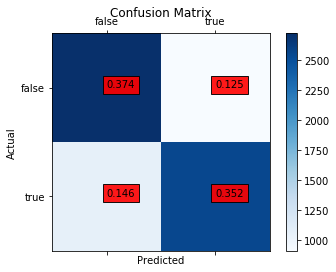

             precision    recall  f1-score   support

      false       0.72      0.75      0.73      3631
       true       0.74      0.71      0.72      3618

avg / total       0.73      0.73      0.73      7249

True Negative: 2722
False Negative: 1060
True Positive: 2558
False Positive: 909


In [5]:
# print(df.head(5))
# print(df['is_prompt_exists'].dtypes)
# a = pd.to_numeric(df['is_prompt_exists'][1])
# print(a + 3)
# print(df['is_prompt_exists'][1])
# print(df['comments'].dtypes)

##################### Tests the input CSV file that was read into Pandas dataframe in above cell
loop = 0
count = 0
numComments = 0
suggestions_per_comment = []
end = len(df)
# end = 1000 # More managable for quick tests
labels = []
predictions = []
for loop in range(end):
    comment = df['comments'][loop]
    prompt = df['is_prompt_exists'][loop]
#     #### Uncomment below condition only when using suggestions_data.csv ####
#     if isinstance(comment, str) == False or (prompt != '1' and prompt != '-1'):
#         continue
#     ####
#     #### Uncomment below condition only when using suggestions_data_balanced.csv ####
    if isinstance(comment, str) == False:
        continue
#     ####
    sentTok = nltk.sent_tokenize(comment)
    modalVerb = False
    foundSuggestion = False
    for sentence in sentTok:
        wordTok = nltk.word_tokenize(sentence)
        words = nltk.pos_tag(wordTok)
        for word in words:
    #         if word[1] == "NNS" or word[1] == "NNP":
    #             count += 1
    #             foundSuggestion = True
    #             break
            if word[1] == "MD":
                modalVerb = True
                continue
            elif word[1] == "VB" or word[1] == "VBZ" or word[1] == "VBP":
                if modalVerb:
                    count += 1
                    foundSuggestion = True
                    break
            elif word[1] == ".":
                phraseList = {"have more", "suggestion", "perhaps", "better if"}
                endSentence = False
                for phrase in phraseList:
                    if (phrase in comment):
                        count += 1
                        foundSuggestion = True
                        endSentence = True
                        break
                if endSentence:
                    break
            modalVerb = False
        if (foundSuggestion):
            break
    actual = df['is_prompt_exists'][loop]
    if (foundSuggestion):
        predictions.append(1)
    else:
        predictions.append(0)
    if (actual == '1' or actual == 1.0):
        labels.append(1)
    else:
        labels.append(0)
    suggestions_per_comment.append(count)
    count = 0
    numComments += 1
#     if (numComments % 1000 == 0): # For timing progress at 1000 step milestones (for large datasets)
#         print(numComments)
    ####### END
print("Total number of suggestions found:", sum(suggestions_per_comment))
# print("Ls:", labels)
# print("Ps:", predictions)
ls = ['false', 'true']
cm = confusion_matrix(labels, predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues) # Bar coloring
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + ls)
ax.set_yticklabels([''] + ls)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.text(s = round(cm[0][0]/end, 3), x = 0, y = 0, color = "black",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[1][1]/end, 3), x = 1, y = 1, color = "black",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[1][0]/end, 3), x = 0, y = 1, color = "black",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[0][1]/end, 3), x = 1, y = 0, color = "black",
         bbox=dict(facecolor='red', alpha=0.9))
plt.show()
print(classification_report(labels, predictions, target_names = ls))
print("True Negative:", cm[0][0])
print("False Negative:", cm[1][0])
print("True Positive:", cm[1][1])
print("False Positive:", cm[0][1])

# [F-Score Metrics](https://en.wikipedia.org/wiki/F1_score)

#### Precision: 
Number of true positives/negatives over total found positives/negatives respectively. This describes how acurately the classifier had labeled the positives and negatives.
#### Recall:
Number of true positives over total found true positives + false negatives. These two categories are considered the relevant instances. The recall for the false section is calculated as the true negatives over the total found false positive/true negative section.
#### F1-Score:
The harmonic mean of precision and recall. The F1-Score is a measure of a test's accuracy. Score ranges from 1 (high) and 0 (low).
##### Note: Sample is not randomly obtained, it runs in order of the csv file from 1 to specified end point.
## For the "suggestions_data.csv" dataset:
### The results of running a small sample of 1000 is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.84      0.20      0.33        644
       true       0.39      0.93      0.55        356
    avg / total   0.68      0.46      0.41       1000

True Negative: 130,
False Negative: 24,
True Positive: 332,
False Positive: 514

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.79      0.83      0.81       644
       true       0.66      0.60      0.63       356
    avg / total   0.74      0.75      0.74      1000
    
True Negative: 534,
False Negative: 143,
True Positive: 213,
False Positive: 110


### The results of running the full sample is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.80      0.05      0.09      6226
       true       0.38      0.98      0.54      3642
    avg / total   0.64      0.39      0.26      9868

True Negative: 288,
False Negative: 72,
True Positive: 3570,
False Positive: 5938

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.81      0.76      0.78      6226
       true       0.63      0.70      0.66      3642
    avg / total   0.74      0.74      0.74      9868

True Negative: 4720,
False Negative: 1091,
True Positive: 2551,
False Positive: 1506

## For the "suggestions_data_tweets.csv" dataset:
### The results of running the full 3000 sample is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.91      0.01      0.01      2762
       true       0.08      0.99      0.15       238
    avg / total   0.84      0.09      0.02      3000

True Negative: 20,
False Negative: 2,
True Positive: 236,
False Positive: 2742

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.94      0.84      0.89      2762
       true       0.18      0.40      0.25       238
    avg / total   0.88      0.81      0.84      3000

True Negative: 2327,
False Negative: 142,
True Positive: 96,
False Positive: 435

## For the "suggestions_trialA.csv" dataset:
### The results of running the full 2500 sample is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.90      0.22      0.35      1915
       true       0.26      0.92      0.41       585
    avg / total   0.75      0.38      0.36      2500

True Negative: 415,
False Negative: 45,
True Positive: 540,
False Positive: 1500

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.84      0.78      0.81      1915
       true       0.41      0.50      0.45       585
    avg / total   0.74      0.71      0.72      2500

True Negative: 1491,
False Negative: 294,
True Positive: 291,
False Positive: 424

The classifier for statments from the SQL query is present below. Run this after running the query in order to classify and count suggestions.

In [5]:
################## Start Classifier
count = 0
numComments = 0
suggestions_per_comment = []
for (id, comment) in cursor:
    if comment == None:
        continue
#     words = nltk.word_tokenize(i)
#     tagged = nltk.pos_tag(words)
#     print(comment, "\n-----------------------------------------\n")
    sentTok = nltk.sent_tokenize(comment)
#     print(sentTok, "\n")
    modalVerb = False
    labeled_comment = [] # List of comments with suggestions labeled
    for sentence in sentTok:
        wordTok = nltk.word_tokenize(sentence)
#         print(wordTok, "\n")
        words = nltk.pos_tag(wordTok)
        prevC = count # TEST
#         print(words, "\n")
        for word in words:
            if word[1] == "NNS":
                count += 1
#                 print("Rule 3 (Nouns):", sentence, '\n')
#                     print(word)
                sentence += "(R:3)"
                labeled_comment.append(sentence)
                break
            elif word[1] == "NNP":
                count += 1
#                 print("Rule 3 (Nouns):", sentence, '\n')
#                     print(word)
                sentence += "(R:3)"
                labeled_comment.append(sentence)
                break
            elif word[1] == "MD":
#                     print(word)
                modalVerb = True
                continue
            elif word[1] == "VB":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == "VBZ":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == "VBP":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == ".": #Modal Verbs: should, could, can, could
                phraseList = {"have more", "suggestion", "perhaps", "better if"}
                original_sentence = sentence
                endSentence = False
                for phrase in phraseList:
                    sentence = (' '.join(wordTok)).lower()
#                     print(sentence, '\n')
                    if (phrase in sentence):
                        count += 1
#                         print("Rule 1 (Pattern Matching):", sentence, '\n')
                        original_sentence += "(R:1)"
                        labeled_comment.append(original_sentence)
                        endSentence = True
                        break
                if endSentence:
                    break
                original_sentence += "(NONE)" # At the end of sentence and no suggestion has been found
                labeled_comment.append(original_sentence)
#             if prevC < count:
#                     print(sentence, '\n')
            modalVerb = False
    suggestions_per_comment.append(count)
#     print(count)
#     print('\n\n')
#     if (count < 3):
#         print("Suggestions:", count)
#         print(labeled_comment, '\n')
#         print(comment, '\n\n')
    count = 0
    numComments += 1
    if numComments == 300:
        break
################## End Classifier
print("Total number of suggestions found:", sum(suggestions_per_comment))
print("Number of unique suggestion counts:", len(set(suggestions_per_comment)))
print("Average number of suggestions per comment:", np.average(suggestions_per_comment))
# print(set(suggestions_per_comment))
# print(suggestions_per_comment)
#### Testing
sentence = "idea"
s1 = nltk.word_tokenize(sentence)
s2 = nltk.pos_tag(s1)
# print('\n', s2)
#### Testing

#Close
cnx.close()

Total number of suggestions found: 778
Number of unique suggestion counts: 12
Average number of suggestions per comment: 2.5933333333333333


Run the below cell to create a histogram of the suggestion classifier results. The metrics involve the number of suggestions found in each comment and how many comments have the indicated number of suggestions.

dict_keys([3, 2, 0, 1, 8, 6, 4, 9, 5, 7, 10, 12])
dict_values([67, 92, 13, 66, 2, 12, 27, 1, 13, 5, 1, 1])


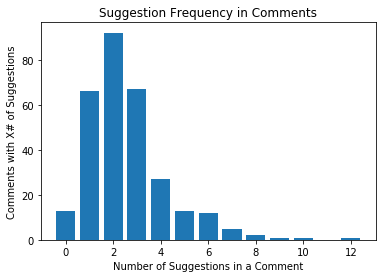

In [6]:
################# Bar Chart Visualization
a = suggestions_per_comment
d = {x:a.count(x) for x in a}
x, y = d.keys(), d.values()

# print(a)
print(x)
print(y)

plt.bar(x, y, label = 'Bars1')
# The X-Axis indicates the range of suggestion quantity present in the comments
plt.xlabel('Number of Suggestions in a Comment')
# The Y-Axis indicates how many comments have the number of suggestions indicated by the X-Axis
plt.ylabel('Comments with X# of Suggestions')
plt.title('Suggestion Frequency in Comments')
plt.show()